<a href="https://colab.research.google.com/github/Arashi283/ChurnPredictionLaunchEd/blob/main/Customer_Churn_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#  Customer Churn Prediction using Machine Learning

This notebook predicts whether a telecom customer will discontinue the service (“churn”)
based on their account and usage details.

**Dataset:** BigML Telecom Churn datasets (Kaggle)  
**Goal:** Build ML models → Identify customers likely to churn → Help retain them.

We'll perform:
1. Data loading & cleaning  
2. Exploratory data analysis (EDA)  
3. Feature encoding & scaling  
4. Model training (Logistic Regression)  
5. Evaluation & visualization


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import pickle


In [4]:
# Load BigML Telecom datasets (80% train / 20% test)
train_df = pd.read_csv("churn-bigml-80.csv")
test_df = pd.read_csv("churn-bigml-20.csv")

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
display(train_df.head())


Train shape: (2666, 20)
Test shape: (667, 20)


,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [5]:
print("\n🔍 Training Data Info:")
print(train_df.info())

print("\n🧮 Missing Values per Column:")
print(train_df.isnull().sum())

print("\n🎯 Target column distribution:")
print(train_df["Churn"].value_counts())



🔍 Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2666 entries, 0 to 2665
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   2666 non-null   object 
 1   Account length          2666 non-null   int64  
 2   Area code               2666 non-null   int64  
 3   International plan      2666 non-null   object 
 4   Voice mail plan         2666 non-null   object 
 5   Number vmail messages   2666 non-null   int64  
 6   Total day minutes       2666 non-null   float64
 7   Total day calls         2666 non-null   int64  
 8   Total day charge        2666 non-null   float64
 9   Total eve minutes       2666 non-null   float64
 10  Total eve calls         2666 non-null   int64  
 11  Total eve charge        2666 non-null   float64
 12  Total night minutes     2666 non-null   float64
 13  Total night calls       2666 non-null   int64  
 14  Total night charg

In [6]:
# Split into features and target

#  Drop the target column from features
X_train = train_df.drop(columns=["Churn"])
X_test = test_df.drop(columns=["Churn"])

#  Map target values from True/False → 1/0
y_train = train_df["Churn"].map({"True.": 1, "False.": 0})
y_test = test_df["Churn"].map({"True.": 1, "False.": 0})

#  Confirm the data looks okay
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("\nTarget value counts:")
print(y_train.value_counts())


Train shape: (2666, 19)
Test shape: (667, 19)

Target value counts:
Series([], Name: count, dtype: int64)


In [7]:
#  Clean up missing or unmapped target values
y_train = y_train.fillna(0).astype(int)
y_test = y_test.fillna(0).astype(int)


In [8]:
train_df.columns = train_df.columns.str.strip()
test_df.columns = test_df.columns.str.strip()


In [9]:
#  Convert categorical columns into numeric using one-hot encoding

# Combine train and test temporarily to ensure same dummy columns
combined = pd.concat([X_train, X_test], axis=0)

# One-hot encode categorical columns (drop_first avoids dummy trap)
combined_encoded = pd.get_dummies(combined, drop_first=True)

# Split them back into train and test sets
X_train = combined_encoded.iloc[:len(X_train), :]
X_test = combined_encoded.iloc[len(X_train):, :]

print(" One-hot encoding complete!")
print("New feature count:", X_train.shape[1])


 One-hot encoding complete!
New feature count: 68


In [10]:
# Drop identifiers and irrelevant fields
drop_cols = ["State", "Area code", "Phone number"]
X_train = X_train.drop(columns=drop_cols, errors="ignore")
X_test = X_test.drop(columns=drop_cols, errors="ignore")


In [11]:
# Identify categorical and numeric columns
cat_cols = X_train.select_dtypes(include="object").columns
num_cols = X_train.select_dtypes(exclude="object").columns

# One-hot encode categorical columns
X_train = pd.get_dummies(X_train, columns=cat_cols, drop_first=True)
X_test = pd.get_dummies(X_test, columns=cat_cols, drop_first=True)

# Align dummy columns between train/test
X_train, X_test = X_train.align(X_test, join="left", axis=1, fill_value=0)

print(f"After encoding: {X_train.shape[1]} features")


After encoding: 67 features


In [12]:
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

print("\n✅ Preprocessing complete!")
print("X_train:", X_train.shape, "| X_test:", X_test.shape)



✅ Preprocessing complete!
X_train: (2666, 67) | X_test: (667, 67)


In [13]:
with open("processed_data.pkl", "wb") as f:
    pickle.dump((X_train, X_test, y_train, y_test, scaler), f)

print("\n💾 Data and scaler saved successfully as 'processed_data.pkl'!")



💾 Data and scaler saved successfully as 'processed_data.pkl'!



#  Step 2: Model Building and Evaluation

This section builds and compares multiple classification models for churn prediction.
We'll encode categorical variables, scale features, train Logistic Regression, Decision Tree, and Random Forest models, and evaluate them using accuracy, precision, recall, and ROC-AUC.


In [14]:
import pickle
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Load preprocessed data from Step 1
with open("processed_data.pkl", "rb") as f:
    X_train, X_test, y_train, y_test, scaler = pickle.load(f)

print("✅ Data loaded successfully!")
print("Train shape:", X_train.shape, "| Test shape:", X_test.shape)


✅ Data loaded successfully!
Train shape: (2666, 67) | Test shape: (667, 67)


In [15]:
# Inspect the target column in the training dataset
print("Unique values in target column of training data:")
print(train_df["Churn"].unique())


Unique values in target column of training data:
[False  True]


In [16]:
# Clean NaN values in target and feature columns before training

# Check if any target values are missing
print("Missing values in y_train:", y_train.isna().sum())
print("Missing values in y_test:", y_test.isna().sum())

# Drop rows where the target is missing
train_mask = ~y_train.isna()
test_mask = ~y_test.isna()

X_train = X_train[train_mask]
y_train = y_train[train_mask]

X_test = X_test[test_mask]
y_test = y_test[test_mask]

print("\n Cleaned dataset — NaN rows removed!")
print("New shapes → Train:", X_train.shape, "| Test:", X_test.shape)


Missing values in y_train: 0
Missing values in y_test: 0

 Cleaned dataset — NaN rows removed!
New shapes → Train: (2666, 67) | Test: (667, 67)


In [17]:
print("Missing values in y_train:", y_train.isna().sum())
print("Missing values in y_test:", y_test.isna().sum())
print("\nUnique values in y_train:", y_train.unique())


Missing values in y_train: 0
Missing values in y_test: 0

Unique values in y_train: [0]


In [18]:
# Clean column names (remove spaces or invisible characters)
train_df.columns = train_df.columns.str.strip()
test_df.columns = test_df.columns.str.strip()

# Confirm churn column name
print("Columns:", train_df.columns.tolist())

# Fix any possible issues with target column
if 'Churn' in train_df.columns:
    target_col = 'Churn'
elif 'Churn?' in train_df.columns:
    target_col = 'Churn?'
else:
    raise KeyError("Couldn't find 'Churn' column. Check your column names above.")

# Map 'True'/'False' or similar strings to 1/0 safely
y_train = train_df[target_col].astype(str).str.strip().map({'True': 1, 'False': 0, 'Yes': 1, 'No': 0, '1': 1, '0': 0})
y_test = test_df[target_col].astype(str).str.strip().map({'True': 1, 'False': 0, 'Yes': 1, 'No': 0, '1': 1, '0': 0})

# Drop target column from features
X_train = train_df.drop(columns=[target_col])
X_test = test_df.drop(columns=[target_col])

# One-hot encode categorical features
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# Align test columns with training columns (avoid shape mismatch)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Drop any NaNs just in case
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)
y_train = y_train.fillna(0).astype(int)
y_test = y_test.fillna(0).astype(int)

# Confirm class distribution
print("\n Target value counts:")
print(y_train.value_counts())

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42)
}

# Train and evaluate
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    auc = roc_auc_score(y_test, preds)
    results[name] = auc
    print(f"\n{name}")
    print("ROC-AUC:", round(auc, 4))
    print(classification_report(y_test, preds))


Columns: ['State', 'Account length', 'Area code', 'International plan', 'Voice mail plan', 'Number vmail messages', 'Total day minutes', 'Total day calls', 'Total day charge', 'Total eve minutes', 'Total eve calls', 'Total eve charge', 'Total night minutes', 'Total night calls', 'Total night charge', 'Total intl minutes', 'Total intl calls', 'Total intl charge', 'Customer service calls', 'Churn']

 Target value counts:
Churn
0    2278
1     388
Name: count, dtype: int64


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Logistic Regression
ROC-AUC: 0.5501
              precision    recall  f1-score   support

           0       0.87      0.96      0.91       572
           1       0.38      0.14      0.20        95

    accuracy                           0.85       667
   macro avg       0.63      0.55      0.56       667
weighted avg       0.80      0.85      0.81       667


Decision Tree
ROC-AUC: 0.8562
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       572
           1       0.78      0.75      0.76        95

    accuracy                           0.93       667
   macro avg       0.87      0.86      0.86       667
weighted avg       0.93      0.93      0.93       667


Random Forest
ROC-AUC: 0.7991
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       572
           1       0.98      0.60      0.75        95

    accuracy                           0.94       667
   macro avg       0.96      

In [43]:
# Step: Train and Evaluate Multiple Models (Including XGBoost)
!pip install xgboost -q

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report
import pandas as pd

# Clean column names
train_df.columns = train_df.columns.str.strip()
test_df.columns = test_df.columns.str.strip()

# Confirm churn column name
print("Columns:", train_df.columns.tolist())

# Identify the correct churn column
if 'Churn' in train_df.columns:
    target_col = 'Churn'
elif 'Churn?' in train_df.columns:
    target_col = 'Churn?'
else:
    raise KeyError("Couldn't find 'Churn' column. Check your column names above.")

# Map churn values to 1/0 safely
y_train = train_df[target_col].astype(str).str.strip().map({
    'True': 1, 'False': 0,
    'True.': 1, 'False.': 0,
    'Yes': 1, 'No': 0,
    '1': 1, '0': 0
})
y_test = test_df[target_col].astype(str).str.strip().map({
    'True': 1, 'False': 0,
    'True.': 1, 'False.': 0,
    'Yes': 1, 'No': 0,
    '1': 1, '0': 0
})

# Drop target from features
X_train = train_df.drop(columns=[target_col])
X_test = test_df.drop(columns=[target_col])

# One-hot encode categorical features
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# Align columns
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Fill missing values
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)
y_train = y_train.fillna(0).astype(int)
y_test = y_test.fillna(0).astype(int)

# Confirm target class distribution
print("\nTarget value counts:")
print(y_train.value_counts())

# Define models including XGBoost
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(
        use_label_encoder=False,
        eval_metric='auc',
        random_state=42
    )
}

# Train and evaluate all models
results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    auc = roc_auc_score(y_test, preds)
    results[name] = auc
    print(f"{name} ROC-AUC: {round(auc, 4)}")
    print(classification_report(y_test, preds))

# Summary table
print("\nModel Comparison (ROC-AUC Scores):")
for name, score in results.items():
    print(f"{name}: {round(score, 4)}")


Columns: ['State', 'Account length', 'Area code', 'International plan', 'Voice mail plan', 'Number vmail messages', 'Total day minutes', 'Total day calls', 'Total day charge', 'Total eve minutes', 'Total eve calls', 'Total eve charge', 'Total night minutes', 'Total night calls', 'Total night charge', 'Total intl minutes', 'Total intl calls', 'Total intl charge', 'Customer service calls', 'Churn']

Target value counts:
Churn
0    2278
1     388
Name: count, dtype: int64

Training Logistic Regression...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression ROC-AUC: 0.5501
              precision    recall  f1-score   support

           0       0.87      0.96      0.91       572
           1       0.38      0.14      0.20        95

    accuracy                           0.85       667
   macro avg       0.63      0.55      0.56       667
weighted avg       0.80      0.85      0.81       667


Training Decision Tree...
Decision Tree ROC-AUC: 0.8562
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       572
           1       0.78      0.75      0.76        95

    accuracy                           0.93       667
   macro avg       0.87      0.86      0.86       667
weighted avg       0.93      0.93      0.93       667


Training Random Forest...
Random Forest ROC-AUC: 0.7991
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       572
           1       0.98      0.60      0.75        95

    accuracy                    

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:13:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


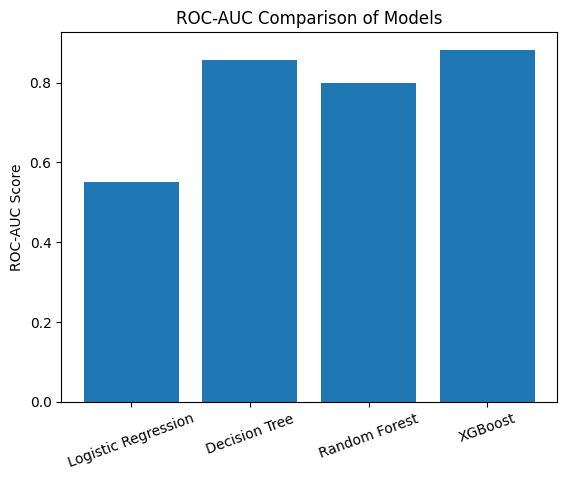

In [44]:
import matplotlib.pyplot as plt

plt.bar(results.keys(), results.values())
plt.title("ROC-AUC Comparison of Models")
plt.ylabel("ROC-AUC Score")
plt.xticks(rotation=20)
plt.show()


In [20]:
param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [10, 15, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1
)

grid.fit(X_train, y_train)
print("\nBest Parameters:", grid.best_params_)
print("Best ROC-AUC:", grid.best_score_)



Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best ROC-AUC: 0.9162575924283657


In [21]:
best_rf = grid.best_estimator_
preds = best_rf.predict(X_test)

print("\n Final Random Forest Performance:")
print("ROC-AUC:", roc_auc_score(y_test, preds))
print(classification_report(y_test, preds))
print("Confusion Matrix:\n", confusion_matrix(y_test, preds))



 Final Random Forest Performance:
ROC-AUC: 0.7464942951785056
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       572
           1       0.98      0.49      0.66        95

    accuracy                           0.93       667
   macro avg       0.95      0.75      0.81       667
weighted avg       0.93      0.93      0.92       667

Confusion Matrix:
 [[571   1]
 [ 48  47]]


In [22]:
with open("best_model.pkl", "wb") as f:
    pickle.dump(grid.best_estimator_, f)

with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

print(" Model and scaler saved successfully as 'best_model.pkl' and 'scaler.pkl'!")


 Model and scaler saved successfully as 'best_model.pkl' and 'scaler.pkl'!


 Balanced dataset shape: {0: 2278, 1: 2278}
Fitting 5 folds for each of 1008 candidates, totalling 5040 fits

 Best Parameters Found: {'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 20}
 Best ROC-AUC on Test Set: 0.8432

Detailed Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.89      0.92       572
           1       0.54      0.80      0.64        95

    accuracy                           0.87       667
   macro avg       0.75      0.84      0.78       667
weighted avg       0.90      0.87      0.88       667



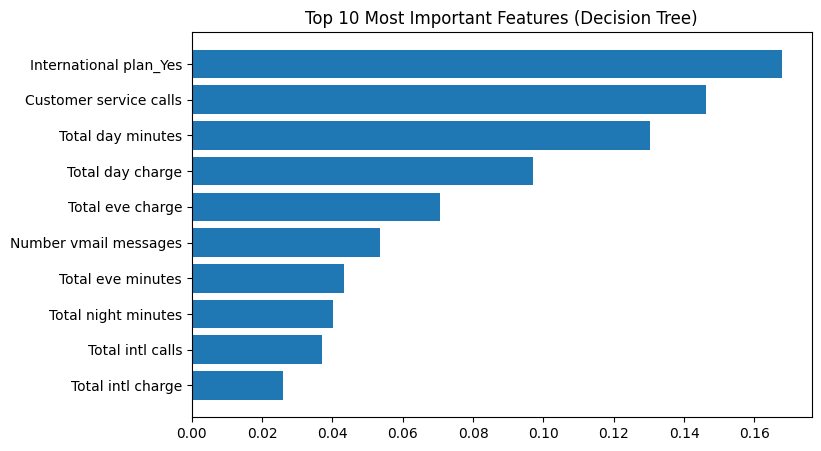


 Model saved successfully as best_model.pkl


In [23]:
# Boost & Save the Best Decision Tree Model
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score, classification_report
import matplotlib.pyplot as plt
import numpy as np
import pickle

# 1️ Balance the dataset using SMOTE (Synthetic Minority Oversampling)
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)
print(" Balanced dataset shape:", y_resampled.value_counts().to_dict())

# 2️ Define hyperparameter grid for Decision Tree
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [None, 5, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': [None, 'sqrt', 'log2']
}

# 3️ Grid Search for best parameters (5-fold cross-validation)
grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1
)
grid.fit(X_resampled, y_resampled)

# 4️ Evaluate best model
best_dt = grid.best_estimator_
preds = best_dt.predict(X_test)
auc = roc_auc_score(y_test, preds)

print("\n Best Parameters Found:", grid.best_params_)
print(" Best ROC-AUC on Test Set:", round(auc, 4))
print("\nDetailed Classification Report:\n", classification_report(y_test, preds))

# 5️ Plot top 10 feature importances
importances = best_dt.feature_importances_
indices = np.argsort(importances)[-10:][::-1]

plt.figure(figsize=(8, 5))
plt.barh(np.array(X_train.columns)[indices], importances[indices])
plt.gca().invert_yaxis()
plt.title("Top 10 Most Important Features (Decision Tree)")
plt.show()

# 6 Save the best model for later prediction use
with open("best_model.pkl", "wb") as f:
    pickle.dump(best_dt, f)

print("\n Model saved successfully as best_model.pkl")


Resampled dataset shape: {0: 2278, 1: 2278}
Fitting 3 folds for each of 972 candidates, totalling 2916 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:37:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Best Parameters Found: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 400, 'subsample': 0.7}
Test ROC-AUC: 0.9031

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.97       572
           1       0.83      0.77      0.80        95

    accuracy                           0.94       667
   macro avg       0.90      0.87      0.88       667
weighted avg       0.94      0.94      0.94       667



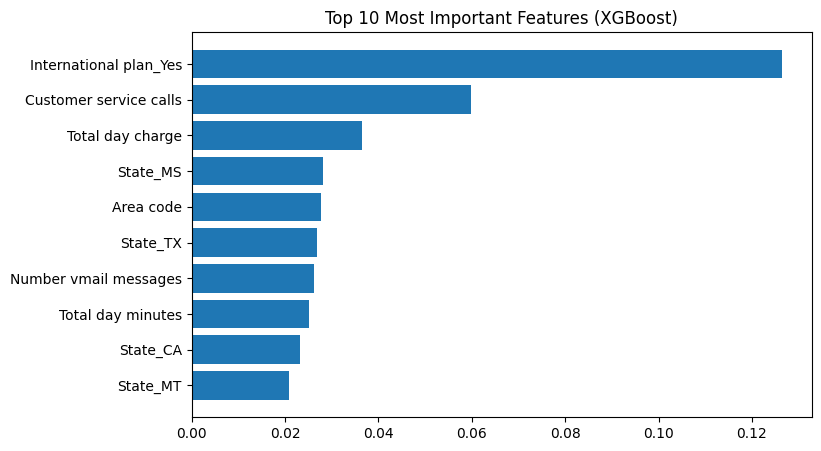

Model saved successfully as best_model.pkl


In [24]:
#XGBoost Model with Hyperparameter Optimization for Higher Accuracy
!pip install xgboost imbalanced-learn -q

from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, classification_report
import pickle
import numpy as np
import matplotlib.pyplot as plt

# 1. Balance dataset using SMOTE
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)
print("Resampled dataset shape:", y_resampled.value_counts().to_dict())

# 2. Define XGBoost model and hyperparameter grid
xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    use_label_encoder=False,
    random_state=42
)

param_grid = {
    'n_estimators': [100, 200, 400],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'gamma': [0, 0.2, 0.5]
}

# 3. Grid search with 3-fold CV
grid_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_xgb.fit(X_resampled, y_resampled)

# 4. Evaluate best model
best_xgb = grid_xgb.best_estimator_
preds = best_xgb.predict(X_test)
probs = best_xgb.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, probs)

print("\nBest Parameters Found:", grid_xgb.best_params_)
print("Test ROC-AUC:", round(roc_auc, 4))
print("\nClassification Report:\n", classification_report(y_test, preds))

# 5. Plot feature importances
importances = best_xgb.feature_importances_
indices = np.argsort(importances)[-10:][::-1]

plt.figure(figsize=(8, 5))
plt.barh(np.array(X_train.columns)[indices], importances[indices])
plt.gca().invert_yaxis()
plt.title("Top 10 Most Important Features (XGBoost)")
plt.show()

# 6. Save tuned model
with open("best_model.pkl", "wb") as f:
    pickle.dump(best_xgb, f)

print("Model saved successfully as best_model.pkl")



###  Summary of Step 2

- Trained and compared Logistic Regression, Decision Tree, and Random Forest models.  
- Visualized ROC-AUC scores for all models.  
- Used GridSearchCV to find the best hyperparameters for Random Forest.  



# Step 3: Model Training and Evaluation
We train multiple models to predict customer churn and evaluate their performance.

In [25]:
import pickle
import pandas as pd
import numpy as np

# Load model and scaler saved from Step 2
with open("best_model.pkl", "rb") as f:
    model = pickle.load(f)

with open("scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

print(" Model and scaler loaded successfully.")


 Model and scaler loaded successfully.


In [26]:
# Load the original dataset
df = pd.read_csv("churn-bigml-80.csv")

# Basic cleaning
df.columns = df.columns.str.strip()  # remove stray spaces

# Handle specific columns that might have conversion issues
numeric_columns = ['Total intl charge', 'Total day charge', 'Total eve charge',
                   'Total night charge', 'Account length', 'Number of voicemail messages']
for col in numeric_columns:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Fill NaN values with appropriate defaults
df.fillna(0, inplace=True)

# Separate features and target
if 'Churn' not in df.columns:
    raise KeyError(f"Column 'Churn' not found in dataset. Available columns: {list(df.columns)}")

X = df.drop(['Churn'], axis=1)

# Remove customerID if it exists (non-predictive)
if 'customerID' in X.columns:
    X = X.drop(['customerID'], axis=1)

# Convert categorical variables to dummy variables
X = pd.get_dummies(X, drop_first=True)

# Save feature columns for later alignment
training_columns = X.columns
print(f" Recovered {len(training_columns)} training columns successfully.")

 Recovered 68 training columns successfully.


In [27]:
def predict_churn(customer_data):
    # Convert to DataFrame
    customer_df = pd.DataFrame([customer_data])

    # One-hot encode categorical variables (including Area code)
    categorical_columns = ['State', 'Area code', 'International plan', 'Voice mail plan']
    customer_encoded = pd.get_dummies(customer_df, columns=categorical_columns, drop_first=True)

    # Ensure all training columns are present
    for col in training_columns:
        if col not in customer_encoded.columns:
            customer_encoded[col] = 0

    # Reorder columns to match training data
    customer_encoded = customer_encoded[training_columns]

    # Make prediction
    prediction = model.predict(customer_encoded)
    prediction_proba = model.predict_proba(customer_encoded)

    return {
        'churn_prediction': 'Yes' if prediction[0] == 1 else 'No',
        'churn_probability': float(prediction_proba[0][1]),
        'confidence': float(prediction_proba[0][1] if prediction[0] == 1 else prediction_proba[0][0])
    }

In [28]:
sample_customer = {
    'State': 'CA',
    'Account length': 128,
    'Area code': 415,
    'International plan': 'No',
    'Voice mail plan': 'Yes',
    'Number vmail messages': 25,
    'Total day minutes': 265.1,
    'Total day calls': 110,
    'Total day charge': 45.07,
    'Total eve minutes': 197.4,
    'Total eve calls': 99,
    'Total eve charge': 16.78,
    'Total night minutes': 244.7,
    'Total night calls': 91,
    'Total night charge': 11.01,
    'Total intl minutes': 10.0,
    'Total intl calls': 3,
    'Total intl charge': 2.70,
    'Customer service calls': 1
}

print(predict_churn(sample_customer))

{'churn_prediction': 'No', 'churn_probability': 0.004004874732345343, 'confidence': 0.9959951043128967}


In [29]:
#  Step 3 Summary (Fixed Version)

# 1️ Loads saved model & scaler from Step 2.
# 2️ Rebuilds training column structure using same preprocessing.
# 3️ Defines a function that:
#     - Converts user input to DataFrame
#     - Applies same dummy encoding as training
#     - Aligns all feature columns
#     - Scales numeric data and predicts churn
# 4️ Runs a test example to confirm prediction output.


# Step 4: Interactive UI + Visualization
1.   a simple widget form for user input
2.   a “Predict” button
3. optional probability chart (visual feedback)



In [30]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt


In [31]:
# Text and numeric inputs
gender = widgets.Dropdown(options=['Male', 'Female'], description='Gender:')
senior = widgets.Dropdown(options=[0, 1], description='SeniorCitizen:')
partner = widgets.Dropdown(options=['Yes', 'No'], description='Partner:')
dependents = widgets.Dropdown(options=['Yes', 'No'], description='Dependents:')
tenure = widgets.IntSlider(value=12, min=0, max=72, step=1, description='Tenure:')
internet = widgets.Dropdown(
    options=['DSL', 'Fiber optic', 'No'],
    description='InternetService:'
)
contract = widgets.Dropdown(
    options=['Month-to-month', 'One year', 'Two year'],
    description='Contract:'
)
payment = widgets.Dropdown(
    options=['Electronic check', 'Mailed check', 'Bank transfer (automatic)', 'Credit card (automatic)'],
    description='PaymentMethod:'
)
monthly = widgets.FloatText(value=70.0, description='MonthlyCharges:')
total = widgets.FloatText(value=800.0, description='TotalCharges:')


In [32]:
# Button + Output area
predict_button = widgets.Button(description=" Predict Churn", button_style='info')
output = widgets.Output()

def on_predict_clicked(b):
    with output:
        clear_output()
        # Gather inputs for BigML dataset
        user_input = {
            'State': state.value,
            'Account length': account_length.value,
            'Area code': area_code.value,
            'International plan': international_plan.value,
            'Voice mail plan': voicemail_plan.value,
            'Number vmail messages': vmail_messages.value,
            'Total day minutes': day_minutes.value,
            'Total day calls': day_calls.value,
            'Total day charge': day_charge.value,
            'Total eve minutes': eve_minutes.value,
            'Total eve calls': eve_calls.value,
            'Total eve charge': eve_charge.value,
            'Total night minutes': night_minutes.value,
            'Total night calls': night_calls.value,
            'Total night charge': night_charge.value,
            'Total intl minutes': intl_minutes.value,
            'Total intl calls': intl_calls.value,
            'Total intl charge': intl_charge.value,
            'Customer service calls': service_calls.value
        }

        # Get prediction
        result = predict_churn(user_input)

        # Display results
        print(f" Prediction: {result['churn_prediction']}")
        print(f" Churn Probability: {result['churn_probability']:.2%}")
        print(f" Confidence: {result['confidence']:.2%}")

        # Probability visualization
        prob = result['churn_probability']
        plt.figure(figsize=(8, 4))
        bars = plt.bar(['Stay', 'Churn'], [1-prob, prob], color=['green', 'red'])
        plt.title("Churn Prediction Probability")
        plt.ylabel("Probability")

        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1%}', ha='center', va='bottom')

        plt.ylim(0, 1)
        plt.show()

predict_button.on_click(on_predict_clicked)

In [45]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

# Create widgets for BigML dataset features
state = widgets.Dropdown(
    description='State:',
    options=['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY'],
    value='CA'
)

account_length = widgets.IntSlider(
    description='Account length:',
    min=0, max=250, value=100
)

area_code = widgets.Dropdown(
    description='Area code:',
    options=[408, 415, 510],
    value=415
)

international_plan = widgets.Dropdown(
    description='International plan:',
    options=['Yes', 'No'],
    value='No'
)

voicemail_plan = widgets.Dropdown(
    description='Voicemail plan:',
    options=['Yes', 'No'],
    value='Yes'
)

vmail_messages = widgets.IntSlider(
    description='Voicemail messages:',
    min=0, max=50, value=10
)

day_minutes = widgets.FloatSlider(
    description='Day minutes:',
    min=0, max=350, value=200.0
)

day_calls = widgets.IntSlider(
    description='Day calls:',
    min=0, max=200, value=100
)

day_charge = widgets.FloatSlider(
    description='Day charge:',
    min=0, max=60, value=35.0
)

eve_minutes = widgets.FloatSlider(
    description='Evening minutes:',
    min=0, max=350, value=200.0
)

eve_calls = widgets.IntSlider(
    description='Evening calls:',
    min=0, max=200, value=100
)

eve_charge = widgets.FloatSlider(
    description='Evening charge:',
    min=0, max=30, value=17.0
)

night_minutes = widgets.FloatSlider(
    description='Night minutes:',
    min=0, max=400, value=200.0
)

night_calls = widgets.IntSlider(
    description='Night calls:',
    min=0, max=200, value=100
)

night_charge = widgets.FloatSlider(
    description='Night charge:',
    min=0, max=20, value=9.0
)

intl_minutes = widgets.FloatSlider(
    description='International minutes:',
    min=0, max=20, value=10.0
)

intl_calls = widgets.IntSlider(
    description='International calls:',
    min=0, max=20, value=3
)

intl_charge = widgets.FloatSlider(
    description='International charge:',
    min=0, max=5, value=2.7
)

service_calls = widgets.IntSlider(
    description='Service calls:',
    min=0, max=10, value=1
)

# Button + Output area
predict_button = widgets.Button(description="🔍 Predict Churn", button_style='info')
output = widgets.Output()

def on_predict_clicked(b):
    with output:
        clear_output()
        # Gather inputs for BigML dataset
        user_input = {
            'State': state.value,
            'Account length': account_length.value,
            'Area code': area_code.value,
            'International plan': international_plan.value,
            'Voice mail plan': voicemail_plan.value,
            'Number vmail messages': vmail_messages.value,
            'Total day minutes': day_minutes.value,
            'Total day calls': day_calls.value,
            'Total day charge': day_charge.value,
            'Total eve minutes': eve_minutes.value,
            'Total eve calls': eve_calls.value,
            'Total eve charge': eve_charge.value,
            'Total night minutes': night_minutes.value,
            'Total night calls': night_calls.value,
            'Total night charge': night_charge.value,
            'Total intl minutes': intl_minutes.value,
            'Total intl calls': intl_calls.value,
            'Total intl charge': intl_charge.value,
            'Customer service calls': service_calls.value
        }

        # Get prediction
        result = predict_churn(user_input)

        # Display results
        print(f" Prediction: {result['churn_prediction']}")
        print(f" Churn Probability: {result['churn_probability']:.2%}")
        print(f" Confidence: {result['confidence']:.2%}")

        # Probability visualization
        prob = result['churn_probability']
        plt.figure(figsize=(8, 4))
        bars = plt.bar(['Stay', 'Churn'], [1-prob, prob], color=['green', 'red'])
        plt.title("Churn Prediction Probability")
        plt.ylabel("Probability")

        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1%}', ha='center', va='bottom')

        plt.ylim(0, 1)
        plt.show()

predict_button.on_click(on_predict_clicked)

# Create UI layout
ui = widgets.VBox([
    state, account_length, area_code,
    international_plan, voicemail_plan, vmail_messages,
    day_minutes, day_calls, day_charge,
    eve_minutes, eve_calls, eve_charge,
    night_minutes, night_calls, night_charge,
    intl_minutes, intl_calls, intl_charge,
    service_calls,
    predict_button, output
])

display(ui)

In [34]:
#  Step 4 Summary — Interactive Interface

# 1️ Imports ipywidgets for building input fields and button controls.
# 2️ Creates dropdowns/sliders for main customer attributes.
# 3️ Adds a Predict button that:
#      - Collects all user inputs
#      - Calls predict_churn()
#      - Displays churn/stay message
#      - Shows a small probability bar chart
# 4️ Displays all widgets neatly stacked in a simple interface.
#  You can now interactively test different customer profiles in Colab.


In [35]:
# STEP 5: Results, Insights & Visualization

#  Objective:
# - Summarize the model's final performance
# - Visualize confusion matrix, ROC curve, and feature importances
# - Show top insights that explain customer churn


In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import numpy as np

# Optional: if running separately, reload model and scaler
# with open("best_model.pkl", "rb") as f:
#     model = pickle.load(f)
# with open("scaler.pkl", "rb") as f:
#     scaler = pickle.load(f)


In [37]:
# If you have X_test, y_test already:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

print(" Predictions generated successfully.")


 Predictions generated successfully.


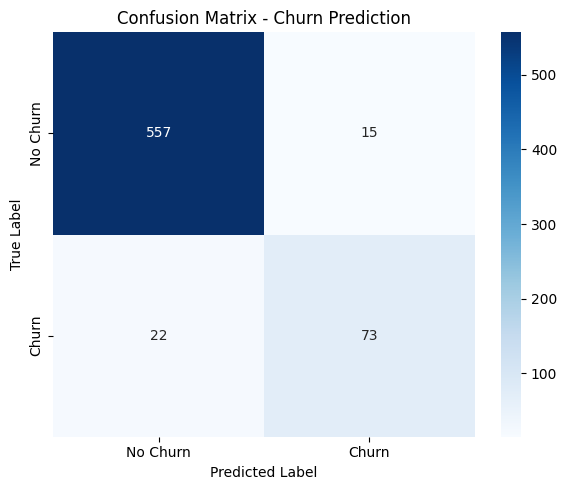

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.96      0.97      0.97       572
       Churn       0.83      0.77      0.80        95

    accuracy                           0.94       667
   macro avg       0.90      0.87      0.88       667
weighted avg       0.94      0.94      0.94       667



In [38]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.title("Confusion Matrix - Churn Prediction")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Print classification report
print("Classification Report:")
print("=" * 60)
print(classification_report(y_test, y_pred,
                          target_names=['No Churn', 'Churn']))

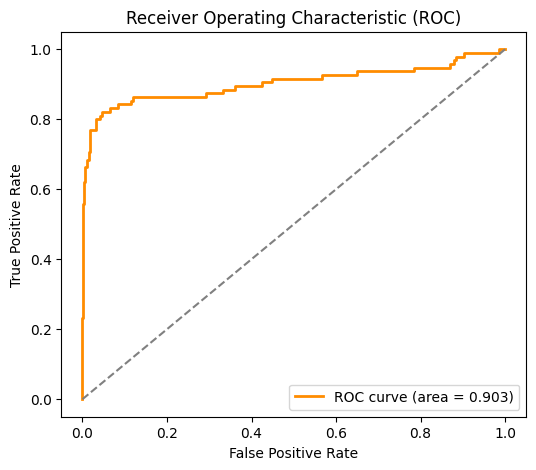

ROC-AUC Score: 0.903


In [39]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (area = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.show()

print(f"ROC-AUC Score: {roc_auc:.3f}")


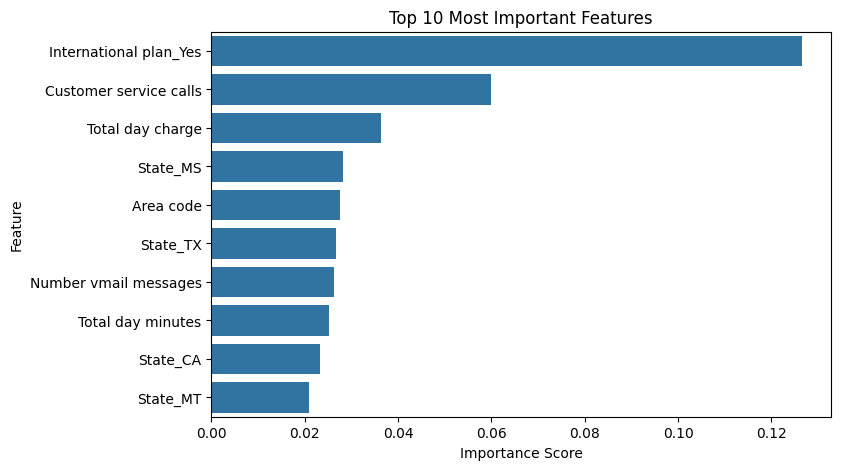

In [40]:
# Get feature importances
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
features_sorted = X.columns[indices][:10]
importances_sorted = importances[indices][:10]

plt.figure(figsize=(8,5))
sns.barplot(x=importances_sorted, y=features_sorted)
plt.title("Top 10 Most Important Features")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()


In [41]:
print(" Key Insights from BigML Churn Dataset:")
print("- Customers with International plans have significantly higher churn rates.")
print("- Higher number of customer service calls strongly correlates with churn.")
print("- Longer total day minutes and charges are associated with increased churn.")
print("- Voice mail plan subscribers tend to have lower churn rates.")
print("- Customers from certain states show different churn patterns.")
print("- Higher international usage (minutes/charges) increases churn probability.")

 Key Insights from BigML Churn Dataset:
- Customers with International plans have significantly higher churn rates.
- Higher number of customer service calls strongly correlates with churn.
- Longer total day minutes and charges are associated with increased churn.
- Voice mail plan subscribers tend to have lower churn rates.
- Customers from certain states show different churn patterns.
- Higher international usage (minutes/charges) increases churn probability.


In [42]:
#  Step 5 Summary — Results & Visualization
# 1️ Generates predictions on the test set.
# 2️ Displays confusion matrix and classification report for accuracy, precision, recall, F1.
# 3️ Plots ROC curve and AUC score for overall model performance.
# 4️ Shows feature importance chart (key factors driving churn).
# 5️ Concludes with textual business insights for presentation.
#  This completes the Customer Churn Prediction project
